# Traffic Sign Recognition with Tensorflow


This notebook is the first part of a tutorial to build a deep learning model for traffic sign recognition. The goal is to build a model that can detect and classify traffic signs in a video stream taken from a moving car. 


## First Objective: Traffic Sign Classification

I'll start with a simple goal: classifiction. Given an image of a traffic sign, our model should be able to tell it's type (e.g. Stop sign, speed limit, yield sign, ...etc.). We'll work with images that are properly cropped such that the traffic sign takes most of the image.


For this project, I'm using Pythong 3.5, Tensorflow 0.11, Numpy, Sci-kit Image, and Matplotlib. All pretty standard tools in machine learning. For convenience, I've created a docker image that contains the most common deep learning tools in one place here: https://hub.docker.com/r/waleedka/modern-deep-learning/ . You can run it with this command:

```
docker run -it -p 8888:8888 -p 6006:6006 -v ~/traffic:/traffic waleedka/modern-deep-learning
```

Note that I have the files of this project in the ~/traffic directory, and I'm it to /traffic directory in the Docker container. Modify this if you're using a different directory.

First step, let's import the needed libraries and get that out of the way.

In [2]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Allow image embeding in notebook
%matplotlib inline

## Trainging Dataset

We're using the Belgian Traffic Sign Dataset. Go to http://btsd.ethz.ch/shareddata/ and download the training and test data. There is a lot of datasets on that page, but you only need the two files listed under **BelgiumTS for Classification (cropped images)**":	
* BelgiumTSC_Training (171.3MBytes)
* BelgiumTSC_Testing (76.5MBytes)

After downloading and expanding the files, your directory structure should look something like this:

```
/traffic/datasets/BelgiumTS/Training/
/traffic/datasets/BelgiumTS/Testing/
```

Each of the two directories above has 62 sub-directories named sequentially from 00000 to 00062. The directory name represents the code (or label) and the images inside the directory are examples of that label. 

## Parse and Load the Training Data

The **Training** directory contains sub-directories with sequental numerical names from 00000 to 00061. The name of the directory represents the labels from 0 to 61, and the images in each directory represent the traffic signs that belong to that label. The images are saved in the not-so-common .ppm format, but luckily, this format is supported in the skimage library.

In [6]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels


# Load training and testing datasets.
ROOT_PATH = "belgium_data"
train_data_dir = os.path.join(ROOT_PATH, "train")
test_data_dir = os.path.join(ROOT_PATH, "test")

images, labels = load_data(train_data_dir)

Here we're loading two lists:
* **images** a list of images, each image is represted by a numpy array.
* **labels** a list of labels. Integers with values between 0 and 61.


It's not usually a good idea to load the whole dataset into memory, but this dataset is small and we're trying to keep the code simple, so it's okay for now. We'll improve it in the next part. For larger datasets, we'd want to have a separate thread loading chunks of data in the background and feeding them to the training thread. 

## Explore the Dataset

How many images and labels do we have?

In [7]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 62
Total Images: 4575


Display the first image of each label.

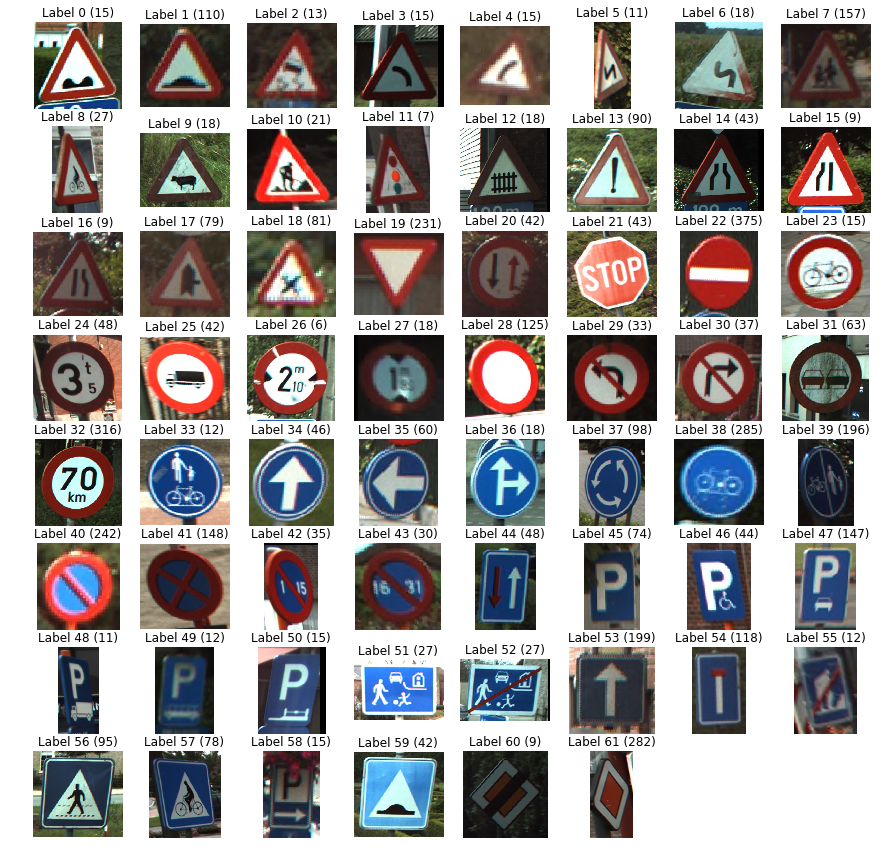

In [8]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

That looks great! The traffic signs occupy most of the area of each image, which is going to make our job easier: we don't have to look for the sign in the image. And we have a variety of angles and lighting conditions, which will help our model generalize. 

However, although the images are square-ish, they're not all the same size. They have different aspect ratios. Our simple neural network takes a fixed-size input, so we have a bit of pre-processing to do. We'll get to that soon, but first let's pick a label and see more of it's images. Let's pick label 32:

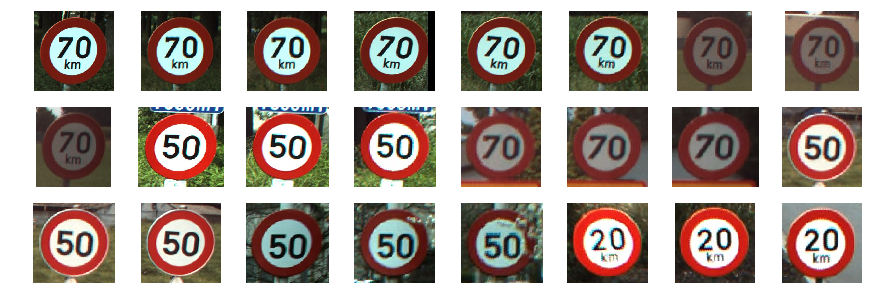

In [9]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 32)

Interesting! It looks like our dataset considers all speeding limit signs to be of the same class regardless of the numbers on them. That's fine, as long as we know about it beforehand and don't let it confuse us later when the output doesn't match our expectation. 

I'll leave exploring other labels as an exercise for you, edit the code above and check other labels. Make sure to check Labels 26 and 27. They also have numbers in a red circle, so our model will have to get really good to differentiate between these 3 classes.

## Handling images of different sizes?

Most neural networks expect a fixed-size input, and our network is no exception. But as we've seen above, our images are not all the same size. A common approach is to crop and pad the images to a selected apect ratio, but then we have to make sure that we don't cut-off parts of the traffic signs in the process. That seems like it might require manual work! Let's do a simpler solution instead (a hack really): We'll just resize the images to a fixed size and ignore the distortions caused by the different aspect ratios. A person can easily recognize a traffic sign even if it's compressed or stretched a bit, so we hope that our model can as well. 

And while we're at it, let's make the images smaller. The larger the input data, the larger the model, and the slower it is to train. In the early stages of development we want fast training to avoid long waits between iterations while we change the code rapidly. 

What are the sizes of our image anyway?

In [10]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (141, 142, 3), min: 0, max: 255
shape: (120, 123, 3), min: 0, max: 255
shape: (105, 107, 3), min: 0, max: 255
shape: (94, 105, 3), min: 7, max: 255
shape: (128, 139, 3), min: 0, max: 255


The sizes seem to hover around 128x128. If we resize them to, say, 32x32, we'll have reduced the data and the model size by a factor of 16. And 32x32 is probably still big enough to recognize the signs, so let's go with that. 

I'm also in the habit of frequently printing the min() and max() values. It's a simple way to verify the range of your data and catch bugs early.

c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


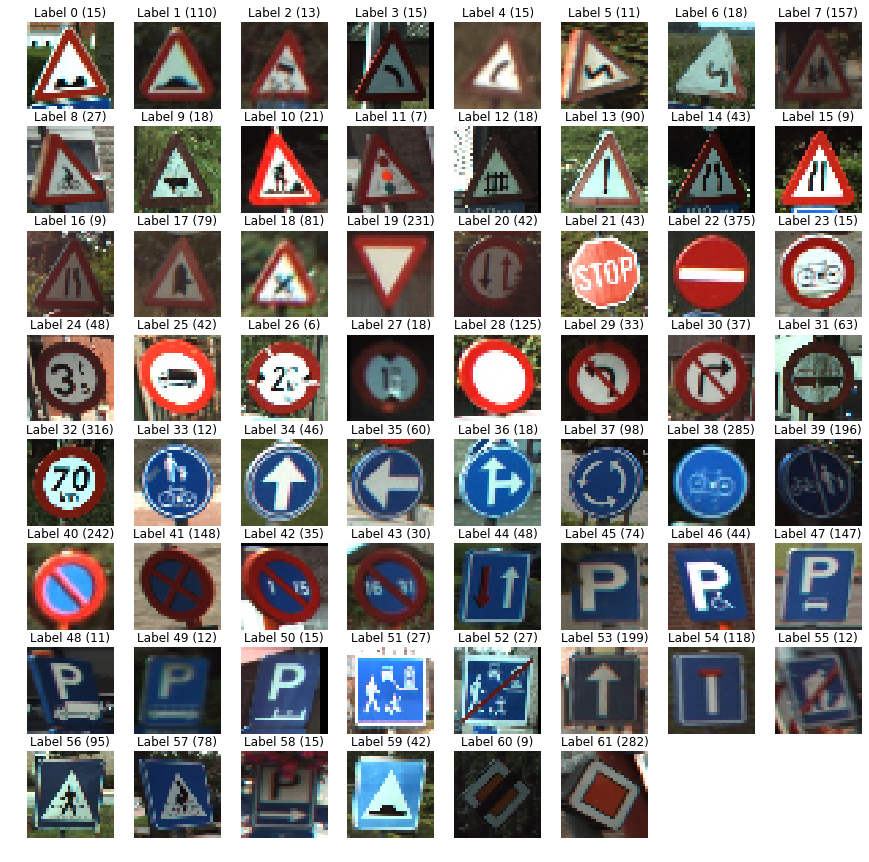

In [11]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

The 32x32 images are not as sharp but still recognizable. Note that the display above shows the images larger than their real size because the matplotlib library tries to fit them to the grid size. Let's print the sizes of a few images to verify that we got it right.

In [12]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.007391237745097998, max: 1.0
shape: (32, 32, 3), min: 0.003576899509805663, max: 1.0
shape: (32, 32, 3), min: 0.0015567555147030507, max: 1.0
shape: (32, 32, 3), min: 0.05677466299019637, max: 0.9692670036764703
shape: (32, 32, 3), min: 0.026654411764708015, max: 0.98952205882353


The sizes are correct. But check the min and max values! They now range from 0 to 1.0, which is different from the 0-255 range we saw above. The resizing function did that transformation for us. Normalizing values to the range 0.0-1.0 is very common so we'll keep it. But remember to multiply by 255 if you later want to convert the images back to the normal 0-255 range.

# Minimum Viable Model

In [13]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (4575,) 
images:  (4575, 32, 32, 3)


In [14]:
# Function to create the model.
tf.reset_default_graph()
def create_model():
    with tf.device('/device:GPU:0'):
        # Placeholders for inputs and labels.
        images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
        labels_ph = tf.placeholder(tf.int32, [None])
        dropout_ph = tf.placeholder(tf.float32, ())
        
        # convolutional layer 1
        conv1 = tf.layers.conv2d(
            inputs=images_ph,
            filters=32,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu,
            kernel_initializer=tf.initializers.random_uniform(-0.1, 0.1))
        
        # max pooling layer 1
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        
        # convolutional layer 2
        conv2 = tf.layers.conv2d(
            inputs=pool1,
            filters=64,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
        
        # max pooling layer 2
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        
        # Flatten features
        images_flat = tf.layers.flatten(pool2)

        # Fully connected layer. 
        logits = tf.contrib.layers.fully_connected(images_flat, 62, activation_fn=None,
                                                   weights_initializer=tf.initializers.random_uniform(-0.1, 0.1))
        
        # dropout layer
        logits = tf.nn.dropout(logits, 1 - dropout_ph)

        # Convert logits to label indexes (int).
        # Shape [None], which is a 1D vector of length == batch_size.
        predicted_labels = tf.argmax(logits, 1)

        # Define the loss and accuracy function. 
        # Cross-entropy is a good choice for classification.
        loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=labels_ph))
        accuracy = tf.metrics.accuracy(labels_ph, predicted_labels)[1]
        
        # Create training op.
        train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    return images_ph, labels_ph, dropout_ph, predicted_labels, loss, accuracy, train

images_ph, labels_ph, dropout_ph, predicted_labels, loss, accuracy, train = create_model()
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

loss:  Tensor("Mean:0", shape=(), dtype=float32, device=/device:GPU:0)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64, device=/device:GPU:0)


## Training

In [15]:
# load test data for evaluation while training
test_images, test_labels = load_data(test_data_dir)

# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]

# Put them into arrays to feed them to tensorflow
test_images32, test_labels = np.array(test_images32), np.array(test_labels)

In [16]:
# Create a session to run the graph we created.
try:
    session = tf.Session()
except ValueError:
    session.close()
    session = tf.Session()

# First step is always to initialize all variables. 
# We don't care about the return value, though. It's None.
_ = session.run(tf.global_variables_initializer())

# weird case with tensorflow metrics (code from stack overflow to initialize it)
running_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES)
session.run(tf.variables_initializer(var_list=running_vars))

step=0
loss
train_loss_list = []
train_acc = []
test_loss_list = []
test_acc = []
steps_list = []

InvalidArgumentError: Cannot assign a device for operation 'conv2d/kernel/Initializer/random_uniform/RandomUniform': Could not satisfy explicit device specification '' because the node was colocated with a group of nodes that required incompatible device '/device:GPU:0'
Colocation Debug Info:
Colocation group had the following types and devices: 
Assign: CPU 
Add: CPU 
Const: CPU 
RandomUniform: CPU 
Sub: CPU 
VariableV2: CPU 
Mul: CPU 
Identity: CPU 
Fill: CPU 
ApplyAdam: CPU 

Colocation members and user-requested devices:
  conv2d/kernel/Initializer/random_uniform/shape (Const) 
  conv2d/kernel/Initializer/random_uniform/min (Const) 
  conv2d/kernel/Initializer/random_uniform/max (Const) 
  conv2d/kernel/Initializer/random_uniform/RandomUniform (RandomUniform) 
  conv2d/kernel/Initializer/random_uniform/sub (Sub) 
  conv2d/kernel/Initializer/random_uniform/mul (Mul) 
  conv2d/kernel/Initializer/random_uniform (Add) 
  conv2d/kernel (VariableV2) /device:GPU:0
  conv2d/kernel/Assign (Assign) /device:GPU:0
  conv2d/kernel/read (Identity) /device:GPU:0
  conv2d/kernel/Adam/Initializer/zeros/shape_as_tensor (Const) /device:GPU:0
  conv2d/kernel/Adam/Initializer/zeros/Const (Const) /device:GPU:0
  conv2d/kernel/Adam/Initializer/zeros (Fill) /device:GPU:0
  conv2d/kernel/Adam (VariableV2) /device:GPU:0
  conv2d/kernel/Adam/Assign (Assign) /device:GPU:0
  conv2d/kernel/Adam/read (Identity) /device:GPU:0
  conv2d/kernel/Adam_1/Initializer/zeros/shape_as_tensor (Const) /device:GPU:0
  conv2d/kernel/Adam_1/Initializer/zeros/Const (Const) /device:GPU:0
  conv2d/kernel/Adam_1/Initializer/zeros (Fill) /device:GPU:0
  conv2d/kernel/Adam_1 (VariableV2) /device:GPU:0
  conv2d/kernel/Adam_1/Assign (Assign) /device:GPU:0
  conv2d/kernel/Adam_1/read (Identity) /device:GPU:0
  Adam/update_conv2d/kernel/ApplyAdam (ApplyAdam) /device:GPU:0

	 [[{{node conv2d/kernel/Initializer/random_uniform/RandomUniform}} = RandomUniform[T=DT_INT32, _class=["loc:@conv2d/kernel"], dtype=DT_FLOAT, seed=0, seed2=0](conv2d/kernel/Initializer/random_uniform/shape)]]

Caused by op 'conv2d/kernel/Initializer/random_uniform/RandomUniform', defined at:
  File "C:\Users\louis\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\louis\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\louis\AppData\Local\Programs\Python\Python36\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\louis\AppData\Local\Programs\Python\Python36\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\Users\louis\AppData\Local\Programs\Python\Python36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\ipykernel\kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tornado\gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tornado\gen.py", line 1080, in __init__
    self.run()
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-bc763a7054ba>", line 57, in <module>
    images_ph, labels_ph, dropout_ph, predicted_labels, loss, accuracy, train = create_model()
  File "<ipython-input-14-bc763a7054ba>", line 17, in create_model
    kernel_initializer=tf.initializers.random_uniform(-0.1, 0.1))
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\layers\convolutional.py", line 417, in conv2d
    return layer.apply(inputs)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 828, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\layers\base.py", line 364, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 759, in __call__
    self.build(input_shapes)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\keras\layers\convolutional.py", line 161, in build
    dtype=self.dtype)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\layers\base.py", line 278, in add_weight
    getter=vs.get_variable)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 586, in add_weight
    aggregation=aggregation)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\training\checkpointable\base.py", line 591, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1484, in get_variable
    aggregation=aggregation)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1234, in get_variable
    aggregation=aggregation)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 538, in get_variable
    aggregation=aggregation)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 492, in _true_getter
    aggregation=aggregation)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 920, in _get_single_variable
    aggregation=aggregation)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\variables.py", line 145, in __call__
    return cls._variable_call(*args, **kwargs)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\variables.py", line 141, in _variable_call
    aggregation=aggregation)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\variables.py", line 120, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2441, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\variables.py", line 147, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\variables.py", line 1104, in __init__
    constraint=constraint)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\variables.py", line 1212, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 894, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\init_ops.py", line 254, in __call__
    shape, self.minval, self.maxval, dtype, seed=self.seed)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\random_ops.py", line 242, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\ops\gen_random_ops.py", line 771, in random_uniform
    name=name)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\framework\ops.py", line 3272, in create_op
    op_def=op_def)
  File "c:\users\louis\documents\python_virtual_env\volvo\lib\site-packages\tensorflow\python\framework\ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cannot assign a device for operation 'conv2d/kernel/Initializer/random_uniform/RandomUniform': Could not satisfy explicit device specification '' because the node was colocated with a group of nodes that required incompatible device '/device:GPU:0'
Colocation Debug Info:
Colocation group had the following types and devices: 
Assign: CPU 
Add: CPU 
Const: CPU 
RandomUniform: CPU 
Sub: CPU 
VariableV2: CPU 
Mul: CPU 
Identity: CPU 
Fill: CPU 
ApplyAdam: CPU 

Colocation members and user-requested devices:
  conv2d/kernel/Initializer/random_uniform/shape (Const) 
  conv2d/kernel/Initializer/random_uniform/min (Const) 
  conv2d/kernel/Initializer/random_uniform/max (Const) 
  conv2d/kernel/Initializer/random_uniform/RandomUniform (RandomUniform) 
  conv2d/kernel/Initializer/random_uniform/sub (Sub) 
  conv2d/kernel/Initializer/random_uniform/mul (Mul) 
  conv2d/kernel/Initializer/random_uniform (Add) 
  conv2d/kernel (VariableV2) /device:GPU:0
  conv2d/kernel/Assign (Assign) /device:GPU:0
  conv2d/kernel/read (Identity) /device:GPU:0
  conv2d/kernel/Adam/Initializer/zeros/shape_as_tensor (Const) /device:GPU:0
  conv2d/kernel/Adam/Initializer/zeros/Const (Const) /device:GPU:0
  conv2d/kernel/Adam/Initializer/zeros (Fill) /device:GPU:0
  conv2d/kernel/Adam (VariableV2) /device:GPU:0
  conv2d/kernel/Adam/Assign (Assign) /device:GPU:0
  conv2d/kernel/Adam/read (Identity) /device:GPU:0
  conv2d/kernel/Adam_1/Initializer/zeros/shape_as_tensor (Const) /device:GPU:0
  conv2d/kernel/Adam_1/Initializer/zeros/Const (Const) /device:GPU:0
  conv2d/kernel/Adam_1/Initializer/zeros (Fill) /device:GPU:0
  conv2d/kernel/Adam_1 (VariableV2) /device:GPU:0
  conv2d/kernel/Adam_1/Assign (Assign) /device:GPU:0
  conv2d/kernel/Adam_1/read (Identity) /device:GPU:0
  Adam/update_conv2d/kernel/ApplyAdam (ApplyAdam) /device:GPU:0

	 [[{{node conv2d/kernel/Initializer/random_uniform/RandomUniform}} = RandomUniform[T=DT_INT32, _class=["loc:@conv2d/kernel"], dtype=DT_FLOAT, seed=0, seed2=0](conv2d/kernel/Initializer/random_uniform/shape)]]


In [148]:
batch_size = 32  # I added batch because gradient descent if faster and it avoids local minimums 
# (it is a classic machine learning move)
n_steps = 20000

for i in range(n_steps):
    if i==0 or data_index + batch_size > len(labels_a) :
        data_index = 0
        indices = np.linspace(0, len(labels_a)-1, len(labels_a), dtype=np.int32)
        np.random.shuffle(indices)
        
    batch_indices = indices[data_index:data_index + batch_size]
    session.run(train,
                feed_dict={images_ph: images_a[batch_indices],
                           labels_ph: labels_a[batch_indices],
                           dropout_ph: 0.5})
    if i % 1000 == 0:
        # Compute train loss and accuracy without dropout on the batch to save some time
        train_loss_value, train_accuracy = session.run([loss, accuracy], 
                            feed_dict={images_ph: images_a[batch_indices],
                                       labels_ph: labels_a[batch_indices],
                                       dropout_ph: 0.0})
        
        # Evaluation on the whole test dataset, without dropout
        test_loss_value, test_accuracy = session.run([loss, accuracy],
                                                     feed_dict={images_ph: test_images32,
                                                                labels_ph: test_labels,
                                                                dropout_ph: 0.0})
        steps_list.append(step)
        train_loss_list.append(train_loss_value)
        train_acc.append(train_accuracy)
        test_loss_list.append(test_loss_value)
        test_acc.append(test_accuracy)
        
        print("********** step {} **********".format(step))
        print("Train loss: ", train_loss_value)
        print("Train accuracy: ", train_accuracy)
        print("Test loss: ", test_loss_value)
        print("Test accuracy: ", test_accuracy)
        
    step += 1
    data_index += batch_size
    

********** step 40000 **********
Train loss:  1.7136293e-07
Train accuracy:  0.93603104
Test loss:  0.41901317
Test accuracy:  0.9365204
********** step 41000 **********
Train loss:  0.0
Train accuracy:  0.93653977
Test loss:  0.43055564
Test accuracy:  0.9370149
********** step 42000 **********
Train loss:  3.72529e-09
Train accuracy:  0.93703365
Test loss:  0.44095266
Test accuracy:  0.93748635
********** step 43000 **********
Train loss:  3.72529e-09
Train accuracy:  0.93750453
Test loss:  0.4511676
Test accuracy:  0.9379453
********** step 44000 **********
Train loss:  0.0
Train accuracy:  0.93796295
Test loss:  0.4599295
Test accuracy:  0.9383664
********** step 45000 **********
Train loss:  0.0
Train accuracy:  0.9383836
Test loss:  0.47383505
Test accuracy:  0.9387693
********** step 46000 **********
Train loss:  0.0
Train accuracy:  0.9387859
Test loss:  0.47158393
Test accuracy:  0.93917996
********** step 47000 **********
Train loss:  0.0
Train accuracy:  0.93919617
Test loss

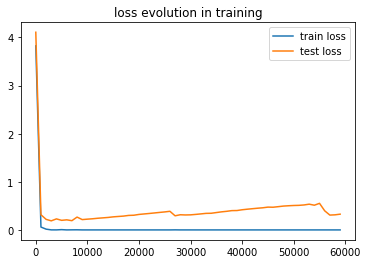

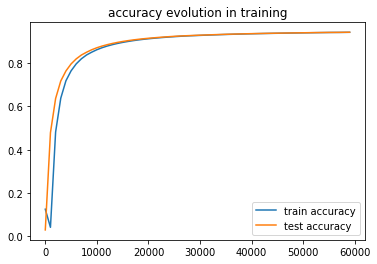

In [149]:
# plot loss
plt.figure()
plt.plot(steps_list, train_loss_list, label="train loss")
plt.plot(steps_list, test_loss_list, label="test loss")
plt.title("loss evolution in training")
plt.legend()

# plot accuracy
plt.figure()
plt.plot(steps_list, train_acc, label="train accuracy")
plt.plot(steps_list, test_acc, label="test accuracy")
plt.title("accuracy evolution in training")
plt.legend()

## Using the Model

The session object contains the values of all the variables in our model (i.e. the weights). 

In [135]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images,
                                   dropout_ph: 0.0})[0]
print(sample_labels)
print(predicted)

[61, 38, 40, 10, 32, 58, 17, 38, 30, 40]
[61 38 40 10 32 58 17 38 30 40]


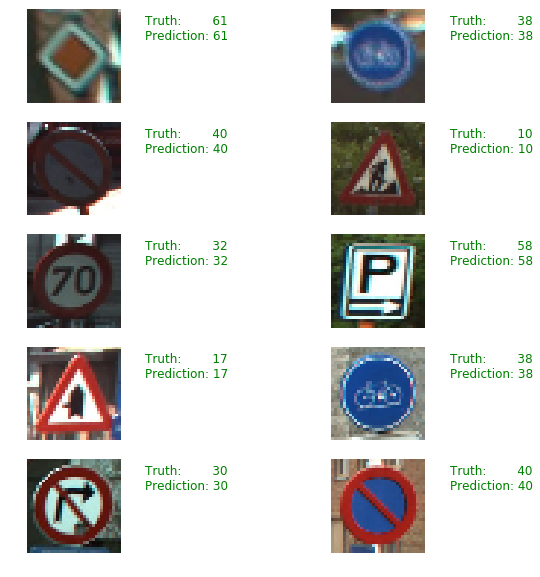

In [136]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])


## Evaluation

It's fun to visualize the results, but we need a more precise way to measure the accuracy of our model. Also, it's important to test it on images that it hasn't seen. And that's where the validation data set comes into play.

In [60]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

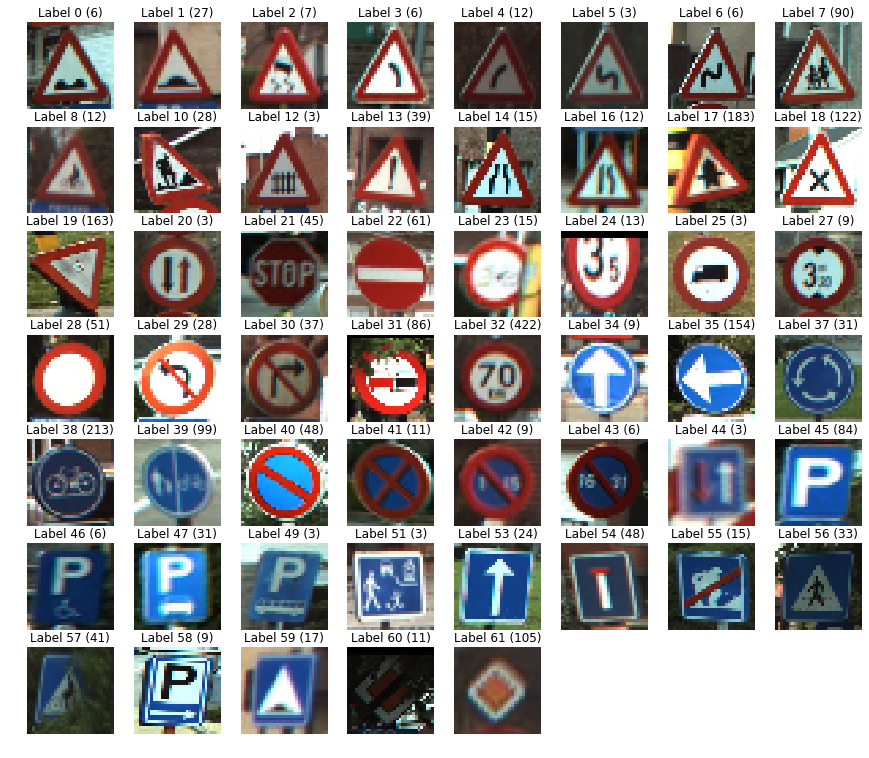

In [61]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [139]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32,
                                   dropout_ph: 0.0})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.957


In [26]:
# Close the session. This will destroy the trained model.
session.close()